In [25]:
import jax

jax.config.update("jax_platform_name", "cpu")
import numpyro

numpyro.set_host_device_count(4)

import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from pymc_experimental.statespace import structural as st

import utils.globalsettings as gs
from utils.sts.simul import stochastic_trend, make_fourier_features

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Ignore warnings about Deprecated
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

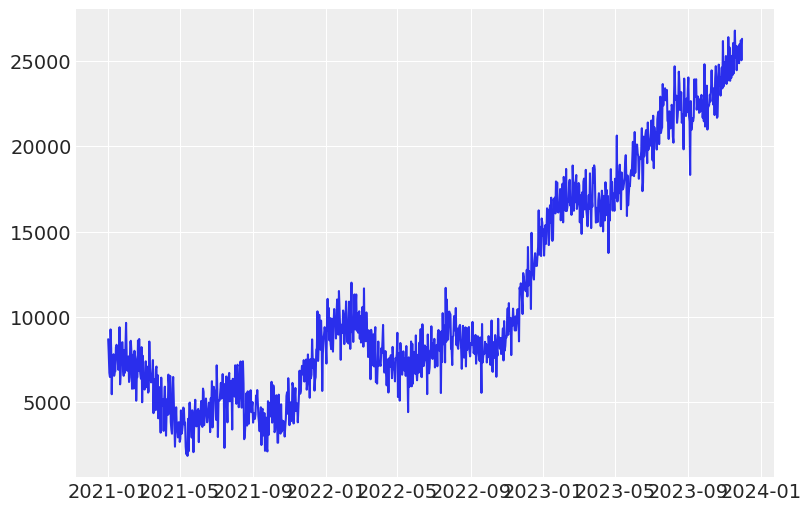

In [18]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

df = pd.concat([
    df, 
    stochastic_trend(
        rng, 
        N = df.shape[0], 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 5000
        )
    ], 
               axis = 1)

fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

df['yr_season'] = 1000 * np.dot(fourier_features, fourier_coefs)

df['y'] = df['local_level'] + df['yr_season'] + rng.normal(0, 1000, df.shape[0])
df.set_index('fecha', inplace=True)
df.index = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')

plt.plot(df.index, df['y'])

In [4]:
y = df["y"].to_numpy()
y_max = np.max(y)
y_min = np.min(y)
y = y / y_max

t = df['t']
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

In [22]:
ll = st.LevelTrendComponent(order=2) # Local level + local trend
se = st.FrequencySeasonality(season_length=365.25, name="annual")

mod = ll + se
ss_mod = mod.build()

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (2,), constraints: Positive, dims: ('trend_shock',)
	annual -- shape: (364,), constraints: None, dims: (annual_initial_state, )
	sigma_annual -- shape: (1,), constraints: Positive, dims: None
	P0 -- shape: (366, 366), constraints: Positive semi-definite, dims: ('state', 'state_aux')


In [23]:
ss_mod.param_dims

{'initial_trend': ('trend_state',),
 'sigma_trend': ('trend_shock',),
 'annual': ('annual_initial_state',),
 'P0': ('state', 'state_aux')}

In [24]:
initial_trend_dims, sigma_trend_dims, annual_dims, P0_dims = ss_mod.param_dims.values()
coords = ss_mod.coords

In [26]:
with pm.Model(coords=coords) as model__trend_season:
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=1, dims=P0_dims[0])
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=P0_dims)
    initial_trend = pm.Normal("initial_trend", sigma=[100, 1], dims=initial_trend_dims)
    annual_seasonal = pm.Normal("annual", sigma=100, dims=annual_dims)

    sigma_trend = pm.Gamma("sigma_trend", alpha=2, beta=1, dims=sigma_trend_dims)
    sigma_monthly_season = pm.Gamma("sigma_annual", alpha=2, beta=1)
    sigma_ar = pm.Gamma("sigma_ar", alpha=2, beta=1)

    ss_mod.build_statespace_graph(df['y'], mode="JAX")
    
    prior_pc = pm.sample_prior_predictive()

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc_experimental\statespace\utils\data_tools.py:96: UserWarning: No frequency was specific on the data's DateTimeIndex.
  warnings.warn(NO_FREQ_INFO_WARNING)
Sampling: [P0_diag, annual, initial_trend, obs, sigma_annual, sigma_ar, sigma_trend]


In [ ]:
prior_pc

In [28]:
with model__trend_season:
    idata = pm.sample(nuts_sampler="numpyro")

Compiling...
c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\sampling\jax.py:678: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:50:11.743809
Sampling...
warmup:   0%|          | 5/2000 [19:29<160:15:17, 289.18s/it, 3 steps of size 1.30e-03. acc. prob=0.20]

In [ ]:
c_prior_pc = ss_mod.sample_conditional_prior()

In [27]:
uc_prior_pc = ss_mod.sample_unconditional_prior()

TypeError: PyMCStateSpace.sample_unconditional_prior() missing 1 required positional argument: 'idata'

In [ ]:
posterior_pc = ss_mod.sample_conditional_posterior(idata)

In [ ]:
az.plot_trace(idata, var_names=ss_mod.param_names);

In [ ]:
component_idata = ss_mod.extract_components_from_idata(post)
component_states = component_idata.coords["state"].values.tolist()
component_states

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(14, 9))
x_values = component_idata.coords["time"]
for axis, name in zip(fig.axes, component_states):
    data = component_idata.predicted_posterior.sel(state=name)
    hdi = az.hdi(data).predicted_posterior
    mean = data.mean(dim=["chain", "draw"])

    axis.plot(x_values, mean)
    axis.fill_between(x_values, *hdi.values.T, color="tab:blue", alpha=0.1)
    axis.set_title(name)
plt.show()

In [ ]:
fig, ax = plt.subplots()
post_stacked = post.stack(sample=["chain", "draw"])
x_values = post_stacked.coords["time"]
hdi_post = az.hdi(post)
post_stacked = post.stack(sample=["chain", "draw"])

ax.plot(
    x_values,
    post_stacked.predicted_posterior.sum(dim="state").mean(dim="sample"),
)
ax.fill_between(x_values, *hdi_post.predicted_posterior.sum(dim="state").values.T, alpha=0.25)
ax.plot(airpass.index, airpass.values)

In [ ]:
forecasts = ss_mod.forecast(idata, start=airpass.index[-1], periods=24)
forecasts = forecasts.stack(sample=["chain", "draw"])

In [ ]:
fig, ax = plt.subplots()
ax.plot(airpass.index, airpass)
ax.plot(
    forecasts.coords["time"],
    forecasts.forecast_observed.values.squeeze(),
    color="tab:orange",
    alpha=0.1,
)
ax.plot(
    forecasts.coords["time"],
    forecasts.forecast_observed.mean(dim="sample").values.squeeze(),
    color="k",
    alpha=1,
)

plt.show()